# Aspect-Based Sentiment Analysis - Exploration & Evaluation

This notebook demonstrates and evaluates all three ABSA implementations:
- **Lexicon-based ABSA**: Using spaCy and sentiment lexicons
- **Transformer-based ABSA**: Using pre-trained Hugging Face models
- **LLM-based ABSA**: Using local LLM through Ollama

## Dataset
We're using 50 Yelp reviews with manually annotated ground truth (253 aspects total)

## Setup and Imports

In [1]:
import sys
import os
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Add parent directory to path for imports
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from src.base import AspectSentiment
from src.lexicon_absa import LexiconABSA
from src.transformer_absa import TransformerABSA
from src.llm_absa import LLMABSA
from src.utils import (
    load_test_data, calculate_accuracy, 
    calculate_precision_recall_f1, benchmark_analyzer
)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful!")

✓ Imports successful!


## Load Test Data with Ground Truth

In [2]:
# Load the annotated test data
data_file = 'data/test_samples.json'
test_data = load_test_data(data_file)

print(f"Loaded {len(test_data)} test samples")

# Calculate ground truth statistics
total_aspects = sum(len(item['ground_truth']) for item in test_data)
sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}

for item in test_data:
    for gt in item['ground_truth']:
        if gt['sentiment'] in sentiment_counts:
            sentiment_counts[gt['sentiment']] += 1

print(f"Total aspects in ground truth: {total_aspects}")
print(f"Average aspects per review: {total_aspects/len(test_data):.2f}")
print(f"\nSentiment distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment.capitalize()}: {count} ({count/total_aspects*100:.1f}%)")

# Show first few samples
print("\n" + "="*70)
print("Sample reviews with ground truth:")
print("="*70)
for i, item in enumerate(test_data[:3], 1):
    print(f"\n{i}. {item['text'][:80]}...")
    print(f"   Ground truth aspects: {len(item['ground_truth'])}")
    for gt in item['ground_truth'][:3]:  # Show first 3 aspects
        print(f"     - {gt['aspect']}: {gt['sentiment']} (confidence: {gt['confidence']})")

Loaded 50 test samples
Total aspects in ground truth: 253
Average aspects per review: 5.06

Sentiment distribution:
  Positive: 185 (73.1%)
  Negative: 53 (20.9%)
  Neutral: 15 (5.9%)

Sample reviews with ground truth:

1. If you decide to eat here, just be aware it is going to take about 2 hours from ...
   Ground truth aspects: 4
     - wait time: negative (confidence: 0.95)
     - food: positive (confidence: 0.75)
     - waitstaff: positive (confidence: 0.65)

2. I've taken a lot of spin classes over the years, and nothing compares to the cla...
   Ground truth aspects: 6
     - classes: positive (confidence: 0.95)
     - space: positive (confidence: 0.85)
     - bikes: positive (confidence: 0.9)

3. Family diner. Had the buffet. Eclectic assortment: a large chicken leg, fried ja...
   Ground truth aspects: 4
     - buffet: positive (confidence: 0.8)
     - food variety: positive (confidence: 0.85)
     - staff: positive (confidence: 0.9)


## Initialize Analyzers

In [3]:
analyzers = {}

print("Initializing analyzers...\n")

# Lexicon-based ABSA
try:
    lexicon_analyzer = LexiconABSA()
    analyzers['Lexicon'] = lexicon_analyzer
    print("✓ LexiconABSA initialized successfully")
except Exception as e:
    print(f"✗ LexiconABSA failed to initialize: {e}")

# Transformer-based ABSA
try:
    transformer_analyzer = TransformerABSA()
    analyzers['Transformer'] = transformer_analyzer
    print("✓ TransformerABSA initialized successfully")
except Exception as e:
    print(f"✗ TransformerABSA failed to initialize: {e}")

# LLM-based ABSA
try:
    llm_analyzer = LLMABSA()
    analyzers['LLM'] = llm_analyzer
    print("✓ LLMABSA initialized successfully")
except Exception as e:
    print(f"✗ LLMABSA failed to initialize: {e}")

print(f"\nSuccessfully initialized {len(analyzers)} analyzers")

Initializing analyzers...

✓ LexiconABSA initialized successfully
Error loading model yangheng/deberta-v3-base-absa-v1.1: 
DebertaV2Tokenizer requires the SentencePiece library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Falling back to alternative ABSA model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ TransformerABSA initialized successfully
✓ LLMABSA initialized successfully

Successfully initialized 3 analyzers


## Quick Test on Sample Reviews

In [4]:
# Test on a few sample texts
test_texts = [
    "The pizza was delicious but the service was terrible.",
    "The laptop has great performance and excellent battery life.",
    "The hotel room was clean and comfortable, but the WiFi was slow."
]

for i, text in enumerate(test_texts, 1):
    print(f"\n{'='*70}")
    print(f"Test {i}: {text}")
    print('='*70)

    for name, analyzer in analyzers.items():
        try:
            start_time = time.time()
            results = analyzer.analyze(text)
            processing_time = time.time() - start_time

            print(f"\n{name} ({processing_time:.3f}s):")
            if results:
                for result in results:
                    print(f"  • {result.aspect}: {result.sentiment} (conf: {result.confidence:.2f})")
            else:
                print("  No aspects found")

        except Exception as e:
            print(f"\n{name} Error: {e}")

Device set to use cpu



Test 1: The pizza was delicious but the service was terrible.

Lexicon (0.016s):
  • service speed: positive (conf: 0.57)
  • pizza: positive (conf: 0.57)
  • service: positive (conf: 0.57)

Transformer (0.178s):
  • service: negative (conf: 0.90)
  • pizza: positive (conf: 0.95)


Device set to use cpu



LLM (12.866s):
  • pizza: positive (conf: 0.90)
  • service: negative (conf: 0.80)

Test 2: The laptop has great performance and excellent battery life.

Lexicon (0.044s):
  • laptop: positive (conf: 0.62)
  • performance: positive (conf: 0.62)
  • battery: positive (conf: 0.62)
  • life: positive (conf: 0.62)
  • great performance: positive (conf: 0.62)
  • excellent battery life: positive (conf: 0.62)

Transformer (0.353s):
  • excellent battery life: positive (conf: 0.98)
  • great performance: positive (conf: 0.99)
  • laptop: positive (conf: 0.99)


Device set to use cpu



LLM (8.982s):
  • performance: positive (conf: 0.90)
  • battery life: positive (conf: 0.80)

Test 3: The hotel room was clean and comfortable, but the WiFi was slow.

Lexicon (0.029s):
  • hotel: positive (conf: 0.51)
  • room: positive (conf: 0.51)
  • wifi: positive (conf: 0.51)
  • hotel room: positive (conf: 0.51)

Transformer (0.129s):
  • wifi: neutral (conf: 0.47)
  • room: positive (conf: 0.59)

LLM (14.541s):
  • cleanliness: positive (conf: 0.90)
  • comfort: positive (conf: 0.80)
  • WiFi speed: negative (conf: 0.70)


## Full Evaluation on Test Set

Now let's evaluate all analyzers on our annotated test set. **Change NUM_SAMPLES_TO_EVALUATE to 50 for full evaluation.**

In [5]:
NUM_SAMPLES_TO_EVALUATE = 10

evaluation_data = test_data[:NUM_SAMPLES_TO_EVALUATE]

print(f"Evaluating on {len(evaluation_data)} samples...\n")

all_results = {}

for name, analyzer in analyzers.items():
    print(f"\nEvaluating {name}...")
    results = benchmark_analyzer(analyzer, evaluation_data, name)
    all_results[name] = results
    
    # Calculate average metrics
    avg_accuracy = np.mean([r['accuracy'] for r in results])
    avg_precision = np.mean([r['precision'] for r in results])
    avg_recall = np.mean([r['recall'] for r in results])
    avg_f1 = np.mean([r['f1'] for r in results])
    avg_time = np.mean([r['processing_time'] for r in results])
    
    print(f"  Accuracy:  {avg_accuracy:.3f}")
    print(f"  Precision: {avg_precision:.3f}")
    print(f"  Recall:    {avg_recall:.3f}")
    print(f"  F1 Score:  {avg_f1:.3f}")
    print(f"  Avg Time:  {avg_time:.3f}s")

print("\n✓ Evaluation complete!")

Evaluating on 10 samples...


Evaluating Lexicon...


Device set to use cpu


  Accuracy:  0.432
  Precision: 0.317
  Recall:    0.762
  F1 Score:  0.416
  Avg Time:  0.028s

Evaluating Transformer...


Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


  Accuracy:  0.472
  Precision: 0.232
  Recall:    0.508
  F1 Score:  0.311
  Avg Time:  0.557s

Evaluating LLM...
  Accuracy:  0.688
  Precision: 0.585
  Recall:    0.663
  F1 Score:  0.610
  Avg Time:  20.009s

✓ Evaluation complete!


## Performance Comparison

In [6]:
# Create comparison DataFrame
comparison_data = []

for name, results in all_results.items():
    comparison_data.append({
        'Method': name,
        'Accuracy': np.mean([r['accuracy'] for r in results]),
        'Precision': np.mean([r['precision'] for r in results]),
        'Recall': np.mean([r['recall'] for r in results]),
        'F1 Score': np.mean([r['f1'] for r in results]),
        'Avg Time (s)': np.mean([r['processing_time'] for r in results]),
        'Total Aspects Found': sum(len(r['aspects']) for r in results)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Method')

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string())


PERFORMANCE COMPARISON
             Accuracy  Precision    Recall  F1 Score  Avg Time (s)  Total Aspects Found
Method                                                                                 
Lexicon      0.431667   0.316531  0.761667  0.416336      0.028272                  116
Transformer  0.471667   0.231883  0.508333  0.311216      0.556504                  110
LLM          0.688333   0.585379  0.663333  0.609520     20.009398                   57


## Visualization

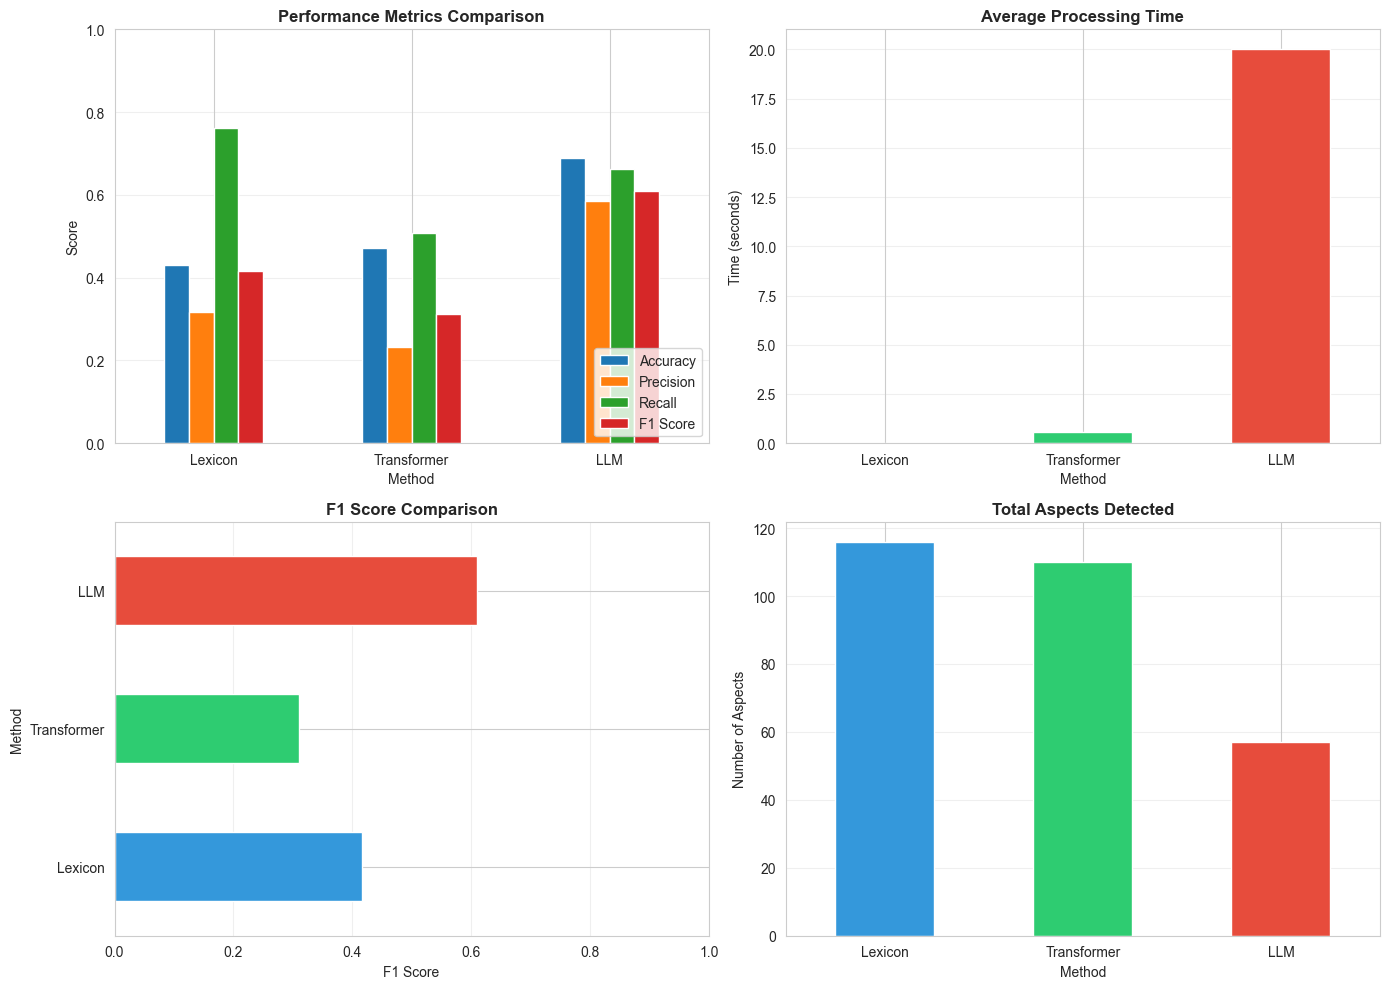

✓ Visualizations generated and saved to doc/performance_comparison.png


In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy, Precision, Recall, F1
metrics_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_df.plot(kind='bar', ax=axes[0, 0], rot=0)
axes[0, 0].set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Processing Time
comparison_df['Avg Time (s)'].plot(kind='bar', ax=axes[0, 1], rot=0, color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Average Processing Time', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: F1 Score Comparison
comparison_df['F1 Score'].plot(kind='barh', ax=axes[1, 0], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1, 0].set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('F1 Score')
axes[1, 0].set_xlim(0, 1.0)
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Total Aspects Found
comparison_df['Total Aspects Found'].plot(kind='bar', ax=axes[1, 1], rot=0, color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1, 1].set_title('Total Aspects Detected', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Aspects')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../doc/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations generated and saved to doc/performance_comparison.png")

## Detailed Analysis: Sample Results

In [8]:
# Show detailed results for first few examples
print("\n" + "="*70)
print("DETAILED ANALYSIS - Sample Results")
print("="*70)

for i in range(min(3, len(evaluation_data))):
    sample = evaluation_data[i]
    print(f"\n{'='*70}")
    print(f"Sample {i+1}")
    print(f"Text: {sample['text'][:100]}...")
    print(f"{'='*70}")
    
    # Ground truth
    print(f"\nGround Truth ({len(sample['ground_truth'])} aspects):")
    for gt in sample['ground_truth']:
        print(f"  • {gt['aspect']}: {gt['sentiment']} (conf: {gt['confidence']})")
    
    # Predictions from each method
    for name, results in all_results.items():
        result = results[i]
        print(f"\n{name} Predictions ({len(result['aspects'])} aspects):")
        if result['aspects']:
            for asp in result['aspects']:
                print(f"  • {asp.aspect}: {asp.sentiment} (conf: {asp.confidence:.2f})")
        else:
            print("  No aspects found")
        print(f"  Accuracy: {result['accuracy']:.3f}, F1: {result['f1']:.3f}")


DETAILED ANALYSIS - Sample Results

Sample 1
Text: If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We...

Ground Truth (4 aspects):
  • wait time: negative (conf: 0.95)
  • food: positive (conf: 0.75)
  • waitstaff: positive (conf: 0.65)
  • service speed: negative (conf: 0.9)

Lexicon Predictions (3 aspects):
  • times: neutral (conf: 0.05)
  • food: negative (conf: 0.54)
  • waitstaff: positive (conf: 0.51)
  Accuracy: 0.250, F1: 0.286

Transformer Predictions (3 aspects):
  • waitstaff: neutral (conf: 0.81)
  • times: positive (conf: 0.57)
  • food: negative (conf: 0.76)
  Accuracy: 0.000, F1: 0.000

LLM Predictions (4 aspects):
  • wait time: negative (conf: 0.80)
  • food quality: positive (conf: 0.70)
  • waitstaff friendliness: neutral (conf: 0.60)
  • restaurant experience: negative (conf: 0.90)
  Accuracy: 0.500, F1: 0.500

Sample 2
Text: I've taken a lot of spin classes over the years, and nothing compares to the classes at B

## Save Results

In [9]:
# Save detailed results to JSON
output_results = {
    'evaluation_summary': comparison_data,
    'num_samples_evaluated': len(evaluation_data),
    'detailed_results': {}
}

for name, results in all_results.items():
    output_results['detailed_results'][name] = [
        {
            'text': r['text'][:100],  # Truncate for readability
            'predictions': [{'aspect': a.aspect, 'sentiment': a.sentiment, 'confidence': a.confidence} 
                           for a in r['aspects']],
            'metrics': {
                'accuracy': r['accuracy'],
                'precision': r['precision'],
                'recall': r['recall'],
                'f1': r['f1'],
                'time': r['processing_time']
            }
        }
        for r in results
    ]

with open('../data/evaluation_results.json', 'w') as f:
    json.dump(output_results, f, indent=2)

print("✓ Results saved to data/evaluation_results.json")

✓ Results saved to data/evaluation_results.json
